# Human Activity Recognition - Trianing ML Models

## Import Required Packages

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

## Initial Setup

In [66]:
# Initialize paths to access required files
activity_labels_path = os.path.join("activity_label.txt")
features_path = os.path.join("features_data.txt")
subject_train_path = os.path.join("train/subject_train_data.txt")
X_train_path = os.path.join("train/X_train_data.txt")
y_train_path = os.path.join("train/y_train_data.txt")
X_test_path = os.path.join("test/X_test_data.txt")
y_test_path = os.path.join("test/y_test_data.txt")

In [68]:
# Read feature names file and clean up to create a list of unique feature names
feature_names = pd.read_csv(features_path, header=None, delim_whitespace=True, names=["index", "feature"])["feature"].tolist()

def make_unique(feature_list):
    counts = Counter()
    unique_features = []
    for feat in feature_list:
        counts[feat] += 1
        if counts[feat] > 1:
            feat = f"{feat}_{counts[feat]}"
        unique_features.append(feat)
    return unique_features

unique_feature_names = make_unique(feature_names)

In [70]:
# Read all the test, train and other data and initialize the variables
activity_labels = pd.read_csv(activity_labels_path, sep="\s+", header=None, names=['id', 'activity'])
subject_train = pd.read_csv(subject_train_path, header=None, names=['Subject'])

X_train = pd.read_csv(X_train_path, delim_whitespace=True, header=None, names=unique_feature_names)
y_train = pd.read_csv(y_train_path, header=None, names=['Activity']).squeeze()
X_test = pd.read_csv(X_test_path, delim_whitespace=True, header=None, names=unique_feature_names)
y_test = pd.read_csv(y_test_path, header=None).squeeze()

## EDA

In [78]:
# Create a single DataFrame
train_df = pd.concat([subject_train, y_train, X_train], axis=1)
activity_map = dict(zip(activity_labels.id, activity_labels.activity))
train_df['Activity'] = train_df['Activity'].map(activity_map)

In [80]:
print("Dataset shape:", train_df.shape)
print("Column types and non-null counts:")
print(train_df.info())

Dataset shape: (7352, 563)
Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, Subject to angle(Z,gravityMean)
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None


### Missing values Check

In [89]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values (if any):")
print(missing_values if not missing_values.empty else "No missing values found.")

Missing values (if any):
No missing values found.


### Duplicate Rows Check

In [87]:
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


### Sample ID v/s Activity

In [93]:
activity_counts = train_df['Activity'].value_counts()
print("\nActivity label distribution:")
print(activity_counts)


Activity label distribution:
Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64


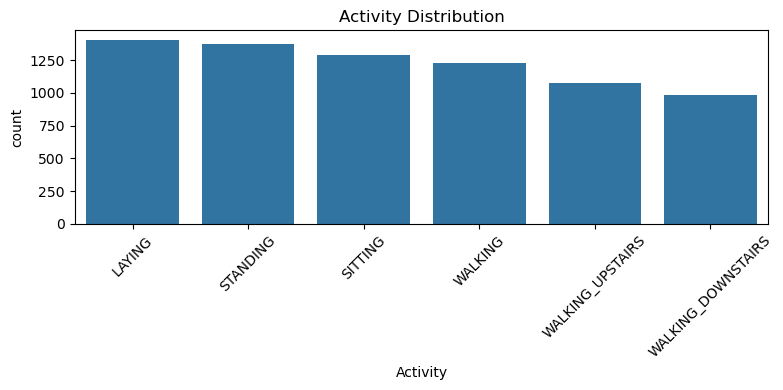

In [29]:
plt.figure(figsize=(8, 4))
sns.countplot(data=train_df, x='Activity', order=train_df['Activity'].value_counts().index)
plt.title('Activity Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Subject Participation per Activity

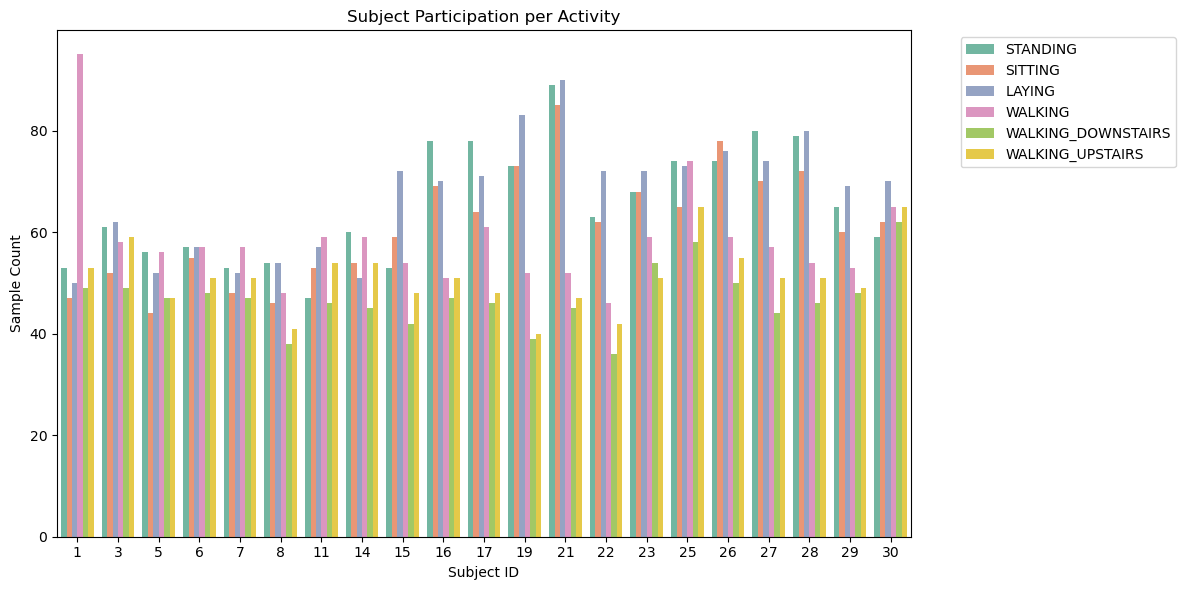

In [96]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='Subject', hue='Activity', palette='Set2')
plt.title('Subject Participation per Activity')
plt.xlabel('Subject ID')
plt.ylabel('Sample Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### PCA Analysis of Activity

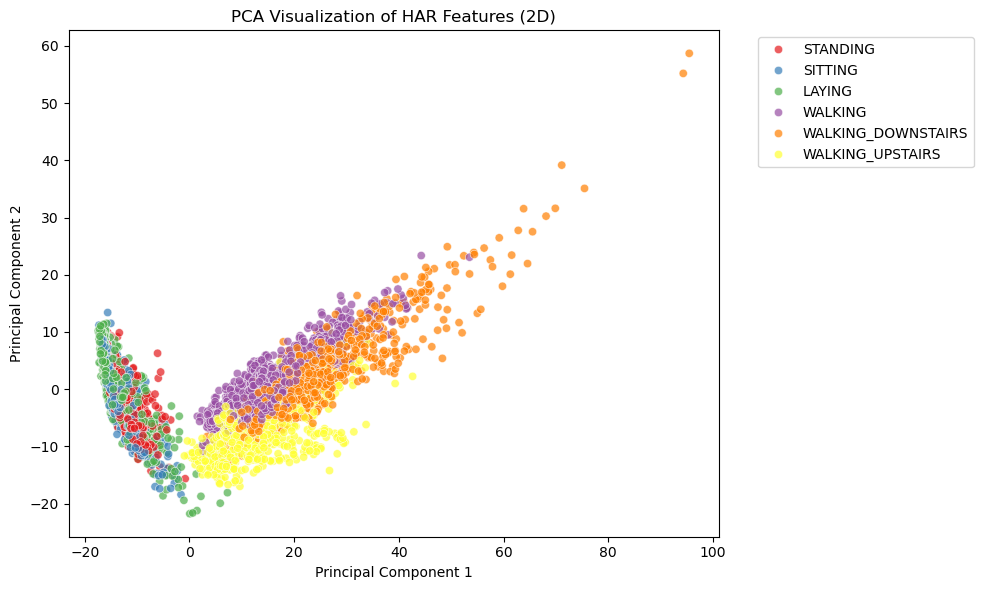

In [99]:
X = train_df.drop(columns=['Subject', 'Activity'])
y = train_df['Activity']


# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Activity'] = y.values

# Visualize PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Activity', palette='Set1', alpha=0.7)
plt.title('PCA Visualization of HAR Features (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Train ML Models

In [139]:
# Read and Map the Activity Data
activity_labels = pd.read_csv(activity_labels_path, header=None, delim_whitespace=True, names=["id", "activity"])
activity_map = dict(zip(activity_labels["id"], activity_labels["activity"]))
y_train_named = y_train.replace(activity_map)
y_test_named = y_test.replace(activity_map)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest Model

In [132]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_named)
rf_preds = rf_model.predict(X_test)

### SVM Model

In [109]:
# Train SVM Model
svm_model = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_model.fit(X_train, y_train_named)
svm_preds = svm_model.predict(X_test)

### Evaluate ML Models

In [112]:
# Model Evaluation
def evaluate_ml_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n{name}:\n  Accuracy: {acc:.4f}\n  F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred, labels=activity_labels["activity"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_labels["activity"])
    disp.plot(xticks_rotation=45)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


Random Forest:
  Accuracy: 0.9250
  F1 Score: 0.9249


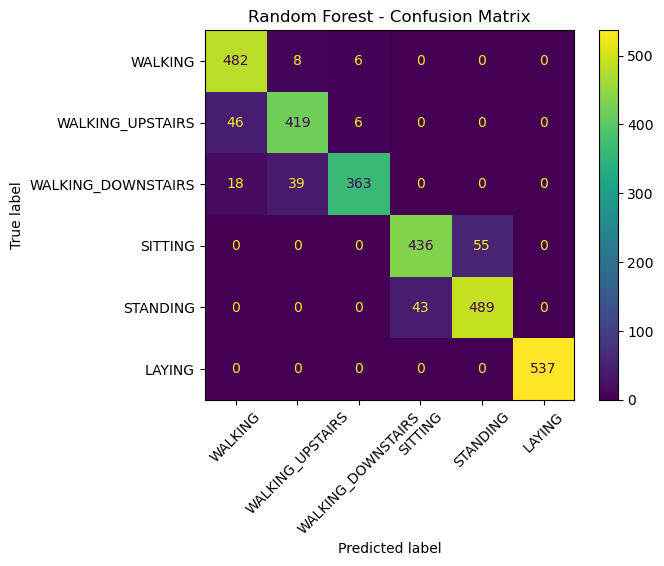


SVM:
  Accuracy: 0.9505
  F1 Score: 0.9504


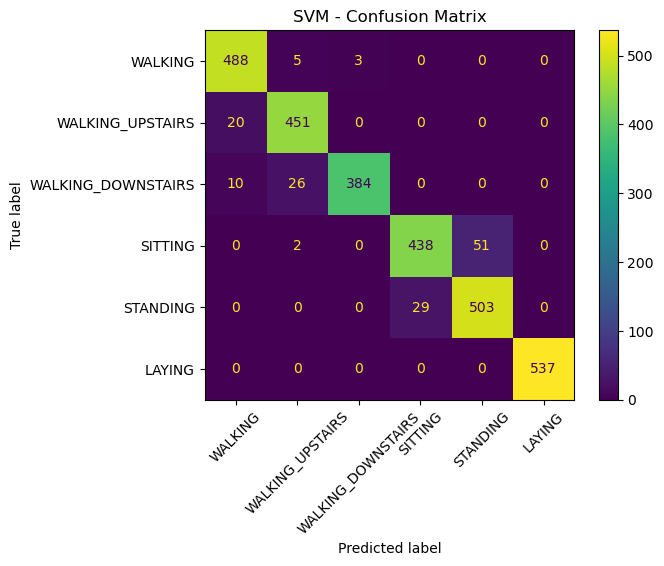

In [114]:
evaluate_ml_model("Random Forest", y_test_named, rf_preds)
evaluate_ml_model("SVM", y_test_named, svm_preds)

## Train Deep Learning Models

In [118]:
# Read Intertial Signal Data
def load_signals(folder):
    signals_path = os.path.join(folder, "Inertial Signals")
    signal_files = sorted(f for f in os.listdir(signals_path) if f.endswith(".txt"))
    signal_data = []
    for file in signal_files:
        data = pd.read_csv(os.path.join(signals_path, file), delim_whitespace=True, header=None).values
        signal_data.append(data)
    return np.transpose(np.array(signal_data), (1, 2, 0)) 

X_train_seq = load_signals("train")
X_test_seq = load_signals("test")

In [120]:
# Encode Labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Normalize Sequences
seq_scaler = StandardScaler()
X_train_seq = seq_scaler.fit_transform(X_train_seq.reshape(-1, X_train_seq.shape[-1])).reshape(X_train_seq.shape)
X_test_seq = seq_scaler.transform(X_test_seq.reshape(-1, X_test_seq.shape[-1])).reshape(X_test_seq.shape)

### CNN Model

In [123]:
# Train CNN Model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

cnn = build_cnn(X_train_seq.shape[1:], y_train_cat.shape[1])
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.fit(X_train_seq, y_train_cat, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6473 - loss: 0.8827 - val_accuracy: 0.9103 - val_loss: 0.3019
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9476 - loss: 0.1404 - val_accuracy: 0.9069 - val_loss: 0.3877
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9573 - loss: 0.0979 - val_accuracy: 0.9232 - val_loss: 0.3271
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9591 - loss: 0.0937 - val_accuracy: 0.9259 - val_loss: 0.3442
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9667 - loss: 0.0752 - val_accuracy: 0.9368 - val_loss: 0.3482


In [125]:
# Train LSTM Model
def build_lstm(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

lstm = build_lstm(X_train_seq.shape[1:], y_train_cat.shape[1])
lstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
lstm.fit(X_train_seq, y_train_cat, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.5005 - loss: 1.2695 - val_accuracy: 0.8348 - val_loss: 0.5038
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8632 - loss: 0.3986 - val_accuracy: 0.8960 - val_loss: 0.4195
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9336 - loss: 0.2100 - val_accuracy: 0.9014 - val_loss: 0.4104
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9330 - loss: 0.2090 - val_accuracy: 0.8960 - val_loss: 0.2775
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9547 - loss: 0.1365 - val_accuracy: 0.9218 - val_loss: 0.2292


### Evaluate DL Models

In [160]:
# Model Evaluation
def evaluate_dl_model(name, model, X, y_true_enc, y_true_cat):
    y_pred = np.argmax(model.predict(X), axis=1)
    acc = accuracy_score(y_true_enc, y_pred)
    f1 = f1_score(y_true_enc, y_pred, average='weighted')
    print(f"\n{name}\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true_enc, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

CNN
Accuracy: 0.9179, F1 Score: 0.9179


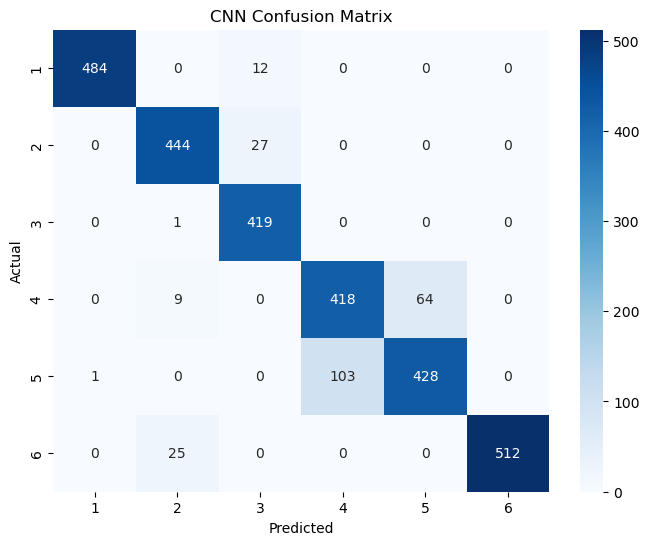

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

LSTM
Accuracy: 0.9036, F1 Score: 0.9027


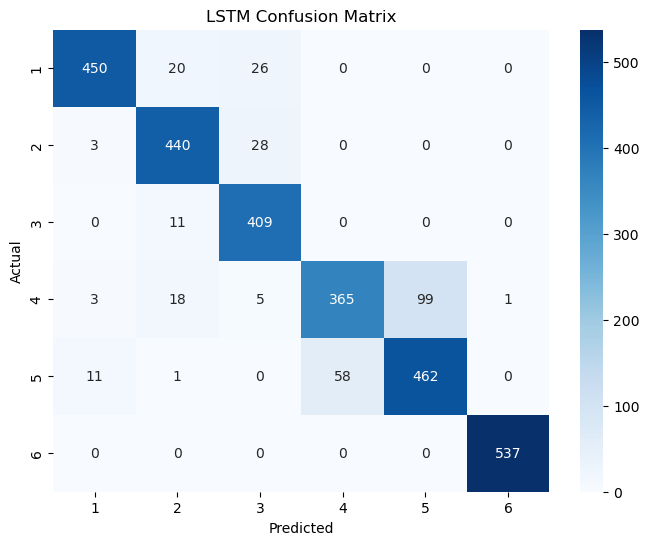

In [130]:
evaluate_dl("CNN", cnn, X_test_seq, y_test_enc, y_test_cat)
evaluate_dl("LSTM", lstm, X_test_seq, y_test_enc, y_test_cat)

## Testing the Models

In [158]:
sample_idx = np.random.randint(len(X_test))

# ML Models
X_test_sample_flat = X_test_scaled[sample_idx].reshape(1, -1)

rf_prediction = rf_model.predict(X_test_sample_flat)[0]
svm_prediction = svm_model.predict(X_test_sample_flat)[0]

print("RF Prediction:", rf_prediction)
print("SVM Prediction:", svm_prediction)

# DL Models
X_test_sample_seq = X_test_seq[sample_idx].reshape(1, X_test_seq.shape[1], X_test_seq.shape[2])

cnn_pred_label = np.argmax(cnn.predict(X_test_sample_seq), axis=1)[0]
lstm_pred_label = np.argmax(lstm.predict(X_test_sample_seq), axis=1)[0]

cnn_prediction = le.inverse_transform([cnn_pred_label])[0]
lstm_prediction = le.inverse_transform([lstm_pred_label])[0]

print("CNN Prediction:", cnn_prediction)
print("LSTM Prediction:", lstm_prediction)

# Actual Label Reference
true_label = y_test_named.iloc[sample_idx]
print("True Label:", true_label)

RF Prediction: LAYING
SVM Prediction: LAYING
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
CNN Prediction: 6
LSTM Prediction: 6
True Label: LAYING
